This tutorial measures the runtime of Global Effect plots, which is mainly influenced by the following factors:

- $t_f$: The runtime of the underlying black-box function, i.e., how much time it takes to apply $f$ on the whole dataset
- $N$: The number of instances, `X = (N,D)`
- $D$: The number of features, `X = (N,D)`
- $T$: The number of points used for centering the feature effect plot.
- $M$: The number of evaluation points

In this tutorial, we'll focus on $t_f$, $N$, and $D$ to measure how each influences the runtime of Global PDP.

In [1]:
import effector
import numpy as np
import timeit
import time
import matplotlib.pyplot as plt
np.random.seed(21)

In [2]:
def return_predict(t):
    def predict(x):
        time.sleep(t)
        model = effector.models.DoubleConditionalInteraction()
        return model.predict(x)
    return predict

def return_jacobian(t):
    def jacobian(x):
        time.sleep(t)
        model = effector.models.DoubleConditionalInteraction()
        return model.jacobian(x)
    return jacobian

In [3]:
def measure_time(method_name, features):
    fit_time_list, eval_time_list = [], []
    X = np.random.uniform(-1, 1, (N, D))
    xx = np.linspace(-1, 1, M)
    axis_limits = np.array([[-1] * D, [1] * D])

    method_map = {
        "pdp": effector.RegionalPDP,
        "d_pdp": effector.RegionalDerPDP,
        "ale": effector.RegionalALE,
        "rhale": effector.RegionalRHALE,
        "shap_dp": effector.RegionalShapDP
    }

    for _ in range(repetitions):
        # general kwargs
        method_kwargs = {"data": X, "model": model, "axis_limits": axis_limits, "nof_instances":"all"}
        fit_kwargs = {"features": features, "centering": True, "points_for_centering": K}

        # specialize kwargs per method
        if method_name in ["d_pdp", "rhale"]:
            method_kwargs["model_jac"] = model_jac
        if method_name in ["rhale", "ale"]:
            fit_kwargs["binning_method"] = effector.binning_methods.Fixed(nof_bins=20, min_points_per_bin=0.)
            fit_kwargs.pop("centering")
            fit_kwargs.pop("points_for_centering")

        # init
        method = method_map[method_name](**method_kwargs)

        # fit
        tic = time.time()
        method.fit(**fit_kwargs)
        fit_time_list.append(time.time() - tic)

        # eval
        tic = time.time()
        for feat in features:
            eval_kwargs = {"feature": feat, "node_idx": 0, "xs": xx, "centering": True, "heterogeneity": True}
            method.eval(**eval_kwargs)
        eval_time_list.append(time.time() - tic)

    return {"fit": np.mean(fit_time_list), "eval": np.mean(eval_time_list), "total": (np.mean(fit_time_list) + np.mean(eval_time_list))}

In [4]:
import matplotlib.pyplot as plt

def bar_plot(xs, time_dict, methods, metric, title, xlabel, ylabel, bar_width=0.02):

    bar_width = (np.max(xs) - np.min(xs)) / 40
    method_to_label = {"ale": "ALE", "rhale": "RHALE", "pdp": "PDP", "d_pdp": "d-pdp", "shap_dp": "SHAP DP"}
    plt.figure()
    
    # Calculate the offsets for each bar group
    offsets = np.linspace(-2*bar_width, 2*bar_width, len(methods))
    
    for i, method in enumerate(methods):
        label = method_to_label[method]
        plt.bar(
            xs + offsets[i],
            [tt[metric] for tt in time_dict[method]],
            label=label,
            width=bar_width
        )
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

## Global methods vs $t_f$

In [5]:
t = 0.001
N = 10_000
D = 5
K = 100
M = 100
repetitions = 2
features=[0]

In [6]:
method_names = ["rhale", "pdp", "d_pdp", ]
vec = np.array([.1, .5, 1.])
time_dict = {method_name: [] for method_name in method_names}
for t in vec:
    model = return_predict(t)
    model_jac = return_jacobian(t)
    for method_name in method_names:
        time_dict[method_name].append(measure_time(method_name, features))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.12s/it]


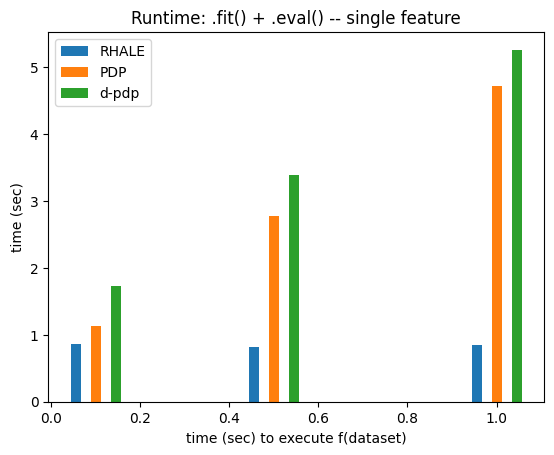

In [7]:
for metric in ["total"]:
    if metric in ["fit", "eval"]:
        title = "Runtime: ." + metric + "() -- single feature"
    else:
        title = "Runtime: .fit() + .eval() -- single feature"
    
    bar_plot(
        vec, 
        time_dict, 
        method_names,
        metric=metric,
        title=title,
        xlabel="time (sec) to execute f(dataset)",
        ylabel="time (sec)"
)

## Time vs. D

In [14]:
t = 0.1
N = 10_000
D = 5
K = 100
M = 100
repetitions = 2
features=[0]

In [15]:
method_names = ["rhale", "pdp", "d_pdp"]
vec = np.array([3, 4, 5, 6])
time_dict = {method_name: [] for method_name in method_names}
for D in vec:
    model = return_predict(t)
    model_jac = return_jacobian(t)
    for method_name in method_names:
        time_dict[method_name].append(measure_time(method_name, features))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]


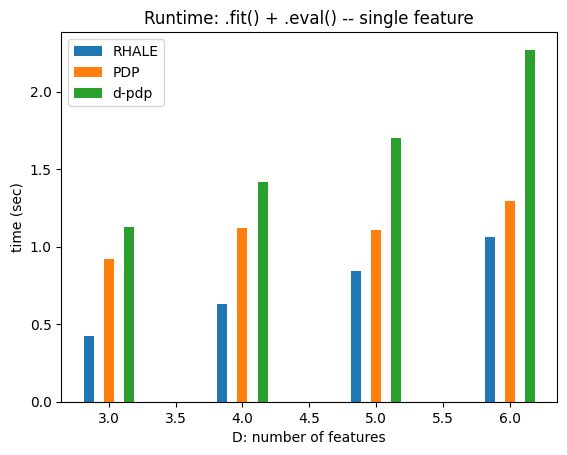

In [16]:
for metric in ["total"]:
    if metric in ["fit", "eval"]:
        title = "Runtime: ." + metric + "() -- single feature"
    else:
        title = "Runtime: .fit() + .eval() -- single feature"
    
    bar_plot(
        vec, 
        time_dict, 
        method_names,
        metric=metric,
        title=title,
        xlabel="D: number of features",
        ylabel="time (sec)"
)

## Time vs N (number of features)

In [11]:
t = 0.1
N = 100_000
D = 5
T = 100
K = 100
repetitions = 2
features=[0]

In [12]:
method_names = ["rhale", "pdp", "d_pdp"]
vec = np.array([10_000, 20_000, 30_000])
time_dict = {method_name: [] for method_name in method_names}
for N in vec:
    model = return_predict(t)
    model_jac = return_jacobian(t)
    for method_name in method_names:
        time_dict[method_name].append(measure_time(method_name, features))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.04s/it]


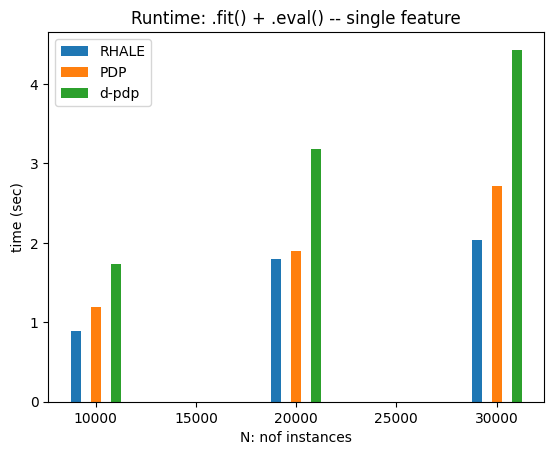

In [13]:
for metric in ["total"]:
    if metric in ["fit", "eval"]:
        title = "Runtime: ." + metric + "() -- single feature"
    else:
        title = "Runtime: .fit() + .eval() -- single feature"
    
    bar_plot(
        vec, 
        time_dict, 
        method_names,
        metric=metric,
        title=title,
        xlabel="N: nof instances",
        ylabel="time (sec)"
)

## A demanding example

In [17]:
t = 0.1
N = 50_000
D = 15
T = 100
K = 100
repetitions = 2
features=[0]

In [18]:
method_names = ["rhale", "pdp", "d_pdp"]
time_dict = {method_name: [] for method_name in method_names}
model = return_predict(t)
model_jac = return_jacobian(t)
for method_name in method_names:
    time_dict[method_name].append(measure_time(method_name, features))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.88s/it]


In [19]:
time_dict

{'rhale': [{'fit': np.float64(17.49294900894165),
   'eval': np.float64(0.03656816482543945),
   'total': np.float64(17.52951717376709)}],
 'pdp': [{'fit': np.float64(12.390817165374756),
   'eval': np.float64(0.4091033935546875),
   'total': np.float64(12.799920558929443)}],
 'd_pdp': [{'fit': np.float64(27.06239879131317),
   'eval': np.float64(0.5038243532180786),
   'total': np.float64(27.56622314453125)}]}